# Telco Customer Churn — Exploratory Data Analysis

This notebook explores the Kaggle Telco Customer Churn dataset (~7k customers, 20+ attributes). We inspect data quality, feature distributions, churn behavior, and correlations to build intuition before modeling.


## 0. Environment & Styling


In [5]:

import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.options.display.max_columns = 50
pd.options.display.float_format = lambda x: f"{x:,.2f}"
RANDOM_STATE = 42


## 1. Load Dataset


In [6]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Initial Overview


In [9]:
df.dtypes


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:

missing_ratio = (df.isna().mean() * 100).sort_values(ascending=False)
missing_ratio.head(10)


customerID        0.00
gender            0.00
SeniorCitizen     0.00
Partner           0.00
Dependents        0.00
tenure            0.00
PhoneService      0.00
MultipleLines     0.00
InternetService   0.00
OnlineSecurity    0.00
dtype: float64

## 3. Data Cleaning & Type Adjustments

* TotalCharges is stored as a string with blank values for newly joined customers — convert to numeric.
* SeniorCitizen is encoded as 0/1 — map to friendly labels for plots.


In [10]:

# Strip whitespace and coerce TotalCharges
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].astype(str).str.strip(), errors='coerce')

# Map SeniorCitizen to Yes/No for readability
if 'SeniorCitizen' in df.columns:
    df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

num_missing_after = df['TotalCharges'].isna().sum() if 'TotalCharges' in df.columns else 0
print(f"Remaining NaNs in TotalCharges: {num_missing_after}")

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


Remaining NaNs in TotalCharges: 11


In [13]:

cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(exclude='object').columns.tolist()



## 4. Target (Churn) Distribution


In [14]:

churn_counts = df['Churn'].value_counts().rename_axis('Churn').reset_index(name='Count')
churn_counts['Percent'] = churn_counts['Count'] / churn_counts['Count'].sum() * 100
churn_counts


,Churn,Count,Percent
0,No,5174,73.46
1,Yes,1869,26.54


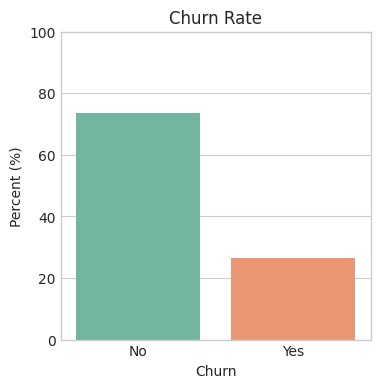

In [15]:

plt.figure(figsize=(4, 4))
sns.barplot(data=churn_counts, x='Churn', y='Percent', hue='Churn', dodge=False, legend=False)
plt.title('Churn Rate')
plt.ylabel('Percent (%)')
plt.ylim(0, 100)
plt.show()


## 5. Numeric Feature Distributions


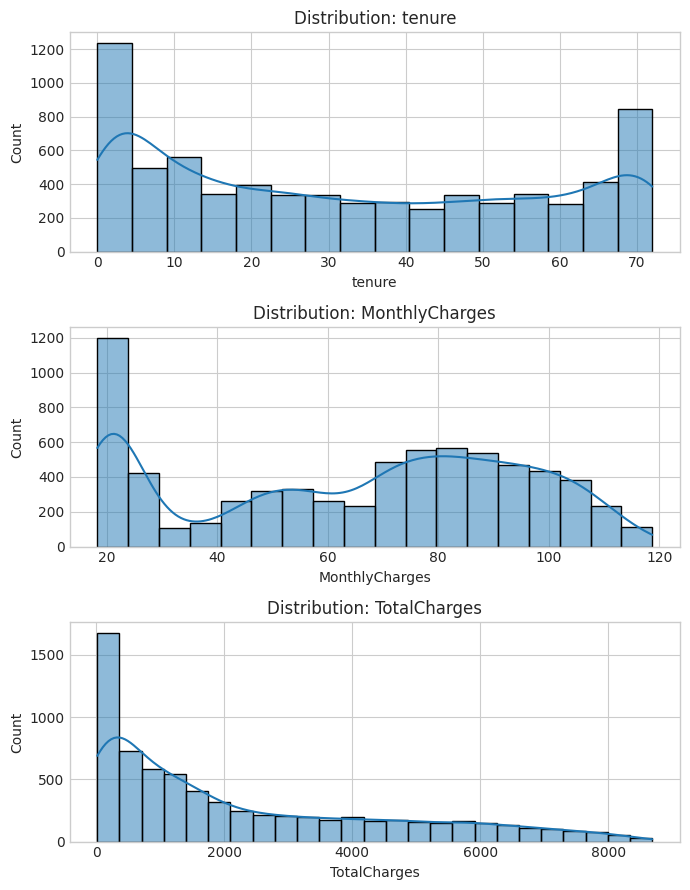

In [16]:

fig, axes = plt.subplots(len(num_cols), 1, figsize=(7, 3 * len(num_cols)))
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    sns.histplot(df[col], kde=True, ax=ax, color='tab:blue')
    ax.set_title(f'Distribution: {col}')
plt.tight_layout()
plt.show()


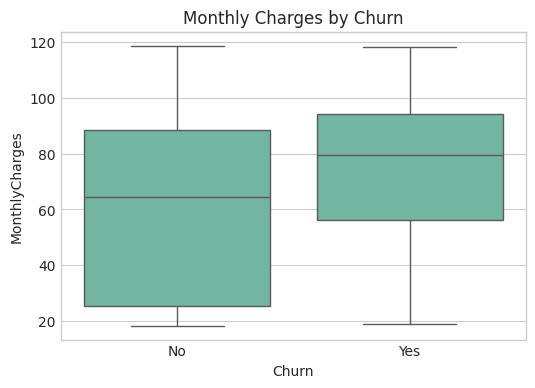

In [17]:

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges by Churn')
plt.show()


## 6. Categorical Features vs. Churn


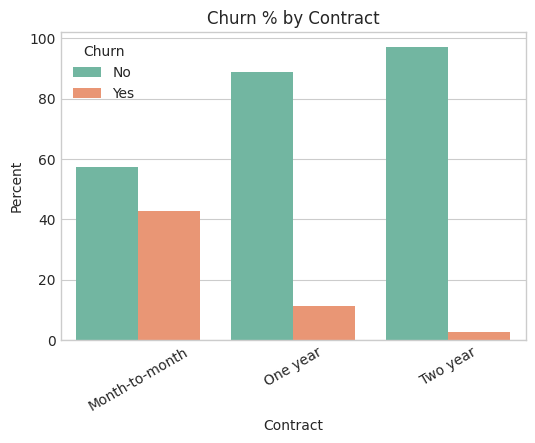

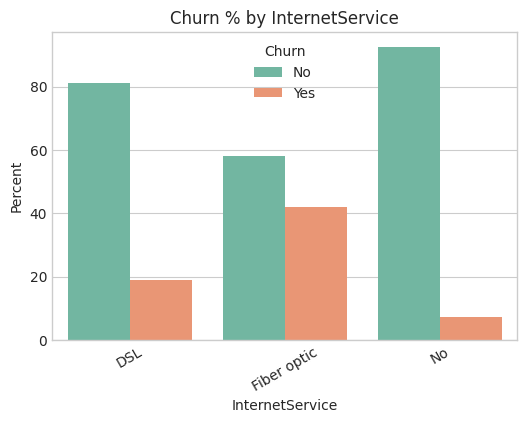

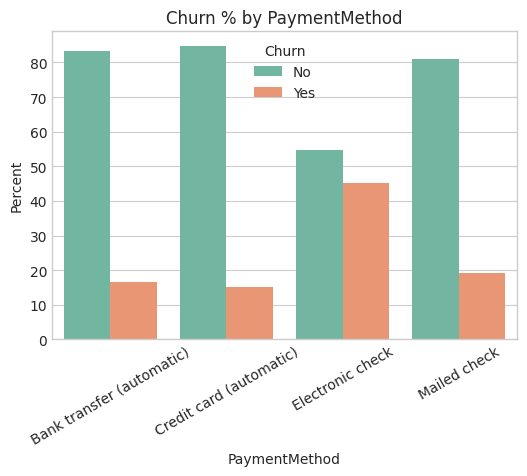

In [20]:

def plot_categorical_relation(col):
    cross_tab = (df.groupby([col, 'Churn']).size().reset_index(name='Count'))
    cross_tab['Percent'] = cross_tab.groupby(col)['Count'].transform(lambda x: x / x.sum() * 100)
    plt.figure(figsize=(6, 4))
    sns.barplot(data=cross_tab, x=col, y='Percent', hue='Churn')
    plt.title(f'Churn % by {col}')
    plt.ylabel('Percent')
    plt.xticks(rotation=30)
    plt.legend(title='Churn')
    plt.show()

for categorical in ['Contract', 'InternetService', 'PaymentMethod']:
    if categorical in df.columns:
        plot_categorical_relation(categorical)


## 7. Correlations


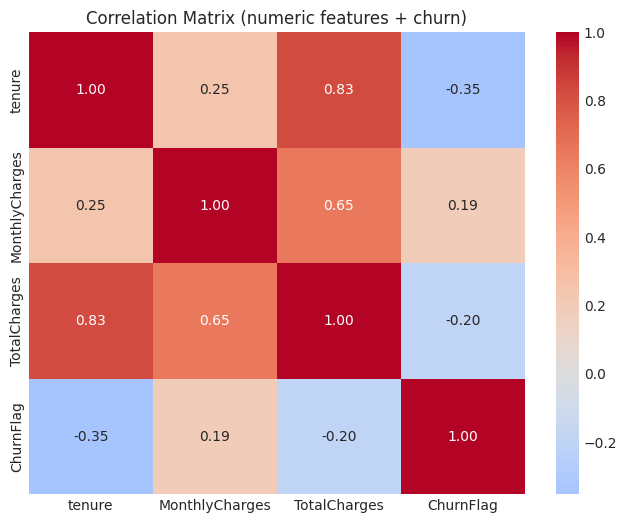

In [21]:

numeric_for_corr = df[num_cols].copy()
if 'Churn' in df.columns:
    numeric_for_corr['ChurnFlag'] = df['Churn'].map({'Yes': 1, 'No': 0}).fillna(0)

corr = numeric_for_corr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix (numeric features + churn)')
plt.show()


## 8. Feature Summaries


In [22]:

df.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043,2,No,5901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,"7,043.00",NaN,NaN,NaN,32.37,24.56,0.00,9.00,29.00,55.00,72.00
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:

data_dict = (
    df[cat_cols]
    .nunique()
    .sort_values(ascending=False)
    .rename('UniqueValues')
)
data_dict


customerID          7043
PaymentMethod          4
StreamingMovies        3
OnlineBackup           3
InternetService        3
OnlineSecurity         3
TechSupport            3
StreamingTV            3
DeviceProtection       3
MultipleLines          3
Contract               3
gender                 2
Dependents             2
PhoneService           2
SeniorCitizen          2
Partner                2
PaperlessBilling       2
Churn                  2
Name: UniqueValues, dtype: int64

## 9. Key Takeaways

* The dataset is reasonably clean; the only notable missing data arises from `TotalCharges`, which we filled with the median.
* Churn rate is roughly one quarter of customers, aligning with the Kaggle description.
* Longer contract terms and paperless billing/payment choices show distinct churn tendencies — useful signals for modeling.
* `MonthlyCharges` and `TotalCharges` highlight pricing tiers; churners skew toward higher monthly bills and shorter tenure.
* Correlations indicate modest relationships; engineered features (tenure buckets, service combinations) may further improve churn separation.

This EDA provides the foundation for feature engineering and model training (e.g., logistic regression, gradient boosting) on the Telco dataset.
